# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

In [4]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage

### Parameters

In [383]:
M=10**4 #number of particles
n_pred=60  #number of predictions
N_daytype=8  #number of day types

In [32]:
#Define functions for filtering and regularization of weigths for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5 - Residual Multinomial Sampling
    #R=sum(np.floor(M*w_h))  #number of (normalized) weights over 1/M
    R=len(w_h[w_h>1/M])
    print("R=",R)
    z=np.zeros(M)
    z[:R]=x_h[w_h>1/M]  #Copy the R particles having weight >1/M
    w_=np.ones(M)
    for j in range(M):
        w_[j]=(M*w_h[j]-np.floor(M*w_h[j]))/(M-R)
    print("w_:",w_)
    z[R:]=np.random.multinomial(1,w_[R:],1)*w_[R:]
    w=np.ones(M)*(1/M)
    return z, w

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

In [7]:
#test the functions on random sample
M=10
x_temp=abs(npr.normal(size=10))
w_temp=np.repeat(0.1,10)*npr.uniform(0.1,1.5,size=10)
#print(w_temp)
xtest,wtest=resid_resample(x_temp,w_temp)
print(xtest)
print(wtest)
M=10**5

R= 3
w_: [ 0.12704705  0.07850309  0.13630215  0.02934793  0.05487552  0.08559799
  0.06857378  0.05559801  0.03633312  0.09269418]
[ 1.13203736  0.09129319  1.28956113  0.          0.          0.          0.
  0.          0.          0.09269418]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


In [8]:
regul(npr.normal(size=10),np.repeat(0.1,10))

array([ 1.18396889,  0.31689609, -1.20762794,  0.76783995,  0.57507185,
       -1.86765881, -0.84237142,  0.95223028, -0.02747446,  1.23902703])

### Load temperatures data

In [9]:
df_temp=pd.read_csv('data/temp_2016.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,t,hour
1707,2016-01-01,9.044444,09:00
1710,2016-01-01,11.005556,18:00
1709,2016-01-01,11.437736,15:00
1708,2016-01-01,11.196296,12:00
1711,2016-01-01,10.683333,21:00


In [10]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [11]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
149461,2016-01-02 08:00:00,2016-01-02,09:00,52975,DÃ©finitive,8
149460,2016-01-02 06:00:00,2016-01-02,07:00,49417,DÃ©finitive,8
149462,2016-01-02 09:00:00,2016-01-02,10:00,55737,DÃ©finitive,8
149463,2016-01-02 10:00:00,2016-01-02,11:00,57237,DÃ©finitive,8
149464,2016-01-02 12:00:00,2016-01-02,13:00,61223,DÃ©finitive,8


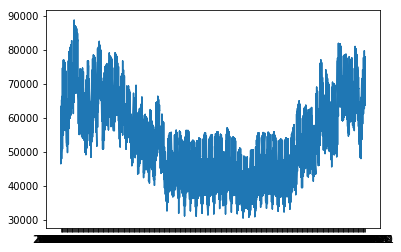

In [575]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

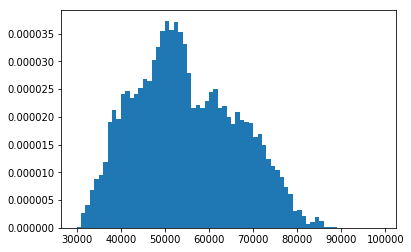

In [228]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

### Set variables of electricity demand for partile 

In [12]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']=='15:00']['Consommation'])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])
temperature_ts = T_h[:30] #france mean temp in jan 2016
daytype_ts = list(df[df['Heure']=='15:00']['daytype'][:30])

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

In [220]:
#Add a bit of noise with uniform random
#s=8000*np.ones(M)*npr.uniform(0.5,1.5,size=M)
#sigma2_g_star=(10**5)*npr.uniform(0.5,1.5,size=M)
#sigma2_s_star=(10**5)*npr.uniform(0.5,1.5,size=M)
sigma_g_init=1.27*10**(8/2)
sigma_s_init=(2*7.9)*10**3
u_h=14 #mean of N(14,1)
kappa=np.array([1/9]*9)
sigma2=2.7*10**7
g_heat_init = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s_init = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)
sigma_s_star_2_evol=7.9*10**7
sigma_g_star_2_evol=1.27*10**8

x_init=x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0]+x_heat(g_heat_init,15,sigma_g_init)[0]
w_init= np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4838: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


In [221]:
x_init[:10]

array([ 11207.26366299, -12211.21377574,  41578.28481568,  21288.25209163,
        17534.93102177,  18438.30767951,   -255.3084417 ,  16757.83731906,
         2232.63649792,   -585.02155657])

In [222]:
print(x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0][:10])

[ 1843.41800756   786.89542877  2274.19344192  1688.18031182  1343.96757308
  2189.02820228  1764.32360492  1236.34429908  1779.03294738  1651.16947868]


In [223]:
print(x_heat(g_heat_init,15,sigma_g_init)[0][:10])

[  92127.66621109   69765.71135115  122067.91192941  102363.89233547
   98954.78400435   99013.10003289   80744.18850903   98285.31357563
   83217.4241062    80527.62952041]


In [61]:
g_heat_init

array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04, ...,
        -1.29732429e+04,  -1.61914297e+04,  -1.74323565e+04])

In [224]:
#Compute w_init
w_init = np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))
#print(w_init[:100])
sum(w_init)/M
sum(np.floor(w_init*M))
w_norm=w_init/np.sum(w_init)
print(sum(np.floor(M*w_norm)))
print(len(w_norm[w_norm>1/M]))

95753.0
6844


In [225]:
np.mean(w_init)

0.032082923777483889

In [156]:
consumption[15]

65044

### Option B: generate initial parameters based on prior distribution

In [ ]:
sigma2=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
g_h = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)


u_h=npr.normal(14,1)  #fixed parameter, invariant to time
k_day=npr.dirichlet(np.ones(N_daytype),1)[0]

C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: overflow encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)


#### 1.B. Calculate x and w at initial state based on initial parameters

In [ ]:
#initialize matrix of x, x_heat, x_season
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])

daytype_init=1
day_init=1

#Calculate x0 and w0 before filtering
x_season[0,:]=k_day[daytype_init]*s
if T_h[day_init]-u_h >0:
    x_heat[0,:]=g_h*(T_h[day_init]-u_h)*1
else:
    x_heat[0,:]=np.zeros(M)

x_0=x_season[0,:]+x_heat[0,:]   #ignore x_cool for now
w0_=x_0+npr.normal(0,sigma2,size=M)  #compute w_wave = g(y_0 l X_0)

#### 2.B.Compute the weights and re-assess the values of X_0 and w_0 based on ESS value


In [186]:
import math
w =np.zeros([n_pred+1,M])  #initalize matrix of weights w
w0_h=w0_/sum(w0_)   #set w_hat
ESS_0=1/(sum(w0_h)**2)  #calculate ESS
if math.isnan(ESS_0):
    ESS_0=1
print(ESS_0)
if ESS_0 <0.001*M:
    x[0,:]=x_0
    w[0,:]=np.ones(M)*(1/M)  #reset the weights
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_0,w0_h)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_0
    w[0,:]=w0_

### Option C: MCMC using MHA or Gibbs (TBA)

In [13]:
import numpy as np
from scipy.stats import truncnorm, invgamma
import math

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [14]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15

In [15]:
#Load pickle file
import pickle
output_file ='data/parameters_init_20180110-102854.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init["x_init"][:20]

array([  1.47891903e+63,   7.69395809e+04,   6.65664387e+04,
         6.81207363e+04,   7.14502802e+04,   5.07239317e+04,
         6.87925901e+04,   6.79254776e+04,   6.64789388e+04,
         6.69291468e+04,   7.02870564e+04,   6.72162235e+04,
         6.13931229e+04,   6.70012333e+04,   6.97843307e+04,
         6.89930685e+04,   6.82153628e+04,   6.36456017e+04,
         7.50874631e+04,   7.18940313e+04])

In [16]:
parameters_init

{'g_heat_init': array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04, ...,
         -1.29732429e+04,  -1.61914297e+04,  -1.74323565e+04]),
 'kappa': array([ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111]),
 's_init': array([  1.33102713e+64,   6.72597280e+05,   1.58876634e+05, ...,
          3.91430788e-08,   3.82795043e-08,   9.78069125e-08]),
 'sigma2': 27000000,
 'sigma_g_init': 1.7189511907681099e+27,
 'sigma_s_init': 6.3306065683604752e-08,
 'u_h': 13,
 'w_init': array([ 0.        ,  0.25286083,  0.94446275, ...,  0.01100679,
         0.88847701,  0.8894034 ]),
 'x_init': array([  1.47891903e+63,   7.69395809e+04,   6.65664387e+04, ...,
          5.27185416e+04,   6.57960826e+04,   7.08387576e+04])}

In [19]:
parameters_init["s_init"][:20]

array([  1.33102713e+64,   6.72597280e+05,   1.58876634e+05,
         1.18739246e+05,   9.82904490e+04,   8.54230162e+04,
         7.64067350e+04,   6.96581133e+04,   6.43746420e+04,
         6.01005169e+04,   5.65553245e+04,   5.35560219e+04,
         5.09775258e+04,   4.87311797e+04,   4.67522382e+04,
         4.49922190e+04,   4.34140299e+04,   4.19887541e+04,
         4.06934668e+04,   3.95097165e+04])

In [20]:
parameters_init["g_heat_init"][:20]

array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04,
        -1.35168312e+04,  -1.48953090e+04,  -1.01466967e+04,
        -1.48396528e+04,  -1.48107955e+04,  -1.45992888e+04,
        -1.48269447e+04,  -1.57502113e+04,  -1.50765346e+04,
        -1.37140601e+04,  -1.51555534e+04,  -1.58945417e+04,
        -1.57479477e+04,  -1.55997181e+04,  -1.45141394e+04,
        -1.73652267e+04,  -1.66117380e+04])

In [148]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
#s_evol=parameters_init['s_evol']
#g_heat_evol=parameters_init['g_heat_evol']
#sigma_s_star_2_evol=parameters_init['sigma_s_star_2_evol']
#sigma_g_star_2_evol=parameters_init['sigma_g_star_2_evol']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [149]:
sigma_g_init=1.27*10**(8/2)*np.ones(M)
sigma_s_init=(2*7.9)*10**3*np.ones(M)

### Part 2: regularize weights and x if necessary

In [152]:
"""
Set of Parameters:
w_init, s_init, g_heat_init, sigma_s_init, sigma_g_init,
x_init, s_evol,g_heat_evol,
sigma_s_star_2_evol, sigma_g_star_2_evol
"""

'\nSet of Parameters:\nw_init, s_init, g_heat_init, sigma_s_init, sigma_g_init,\nx_init, s_evol,g_heat_evol,\nsigma_s_star_2_evol, sigma_g_star_2_evol\n'

In [428]:
#STEP 2 OF PARTICLE FILTER
def resample(x_pred,w_prev,len_init,n,sigma_s,sigma_g,g_h,s,sigma):   
    #compute y_n
    delta_cons_gaus=-np.square(consumption_day_ahead[len_init+n]-x_pred)/(2*sigma**2)
    y_n=np.exp(delta_cons_gaus)
    #compute new weights
    if n>0:
        w_=w_prev*y_n
    else:
        w_=w_prev
    #likelihood of y_n
    lh_y_n=np.sum(delta_cons_gaus)
    #normalize weights
    w_h=w_/sum(w_)
    #calculate ESS
    ESS=1/sum(np.square(w_h))
    x =np.zeros(M)
    w =np.zeros(M)
    print("ESS of normalized weights=",round(ESS,6))
    if ESS <0.001*M: #reset the weights, keep x predicted as such
        print("ESS <0.001*M")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
    elif (ESS>=0.001*M and ESS<0.5*M):  #reset all the weights, add some noise to a fraction of the x's
        print("ESS>=0.001*M and ESS_0<0.5*M")
        #x_temp,w_temp=resid_resample(x_pred,w_h)
        #x=regul(x_temp,w_temp)
        #w=w_temp
        x,w,sigma_s,sigma_g,g_h,s=resample_multinomial(x_pred,sigma_s,sigma_g,g_h,s)
    elif ESS>=0.5*M:  #No degeneracy
        print("ESS>=0.5*M")
        x=x_pred
        w=w_h
    else:
        print("ESS critically low")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
            
    print("new ESS=",round(1/sum(np.square(w)),6))
    return x,w,ESS,lh_y_n,sigma_s,sigma_g,g_h,s

In [429]:
def resample_multinomial(x_temp,sigma_s,sigma_g,g_h,s):
    multinomial = np.random.multinomial(1,w_temp,M)
    new_x = np.zeros(M)
    new_s = np.zeros(M)
    new_g_heat = np.zeros(M)
    new_sigma_s = np.zeros(M)
    new_sigma_g = np.zeros(M)
    for i in range(M):
        new_x[i]=x_temp[np.argmax(multinomial[i,])]
        new_s[i]=s[np.argmax(multinomial[i,])]
        new_g_heat[i]=g_h[np.argmax(multinomial[i,])]
        new_sigma_s[i]=sigma_s[np.argmax(multinomial[i,])]
        new_sigma_g[i]=sigma_g[np.argmax(multinomial[i,])]
    new_w=(1/M)*np.ones(M)   
    return new_x,new_w,new_sigma_s,new_sigma_g,new_g_heat,new_s

In [430]:
#initialize matrix of x_heat, x_season
ESS=np.array(np.ones(n_pred+1))
x =np.zeros([n_pred+1,M])
w =np.zeros([n_pred+1,M])
lh_y_n =np.zeros(n_pred+1)
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])

x[0,:],w[0,:],ESS[0],lh_y,sigma_s_init,sigma_g_init,g_heat_init,s_init=resample(x_init,w_init,15,0,sigma_s_init,
                                                                                sigma_g_init,
                                                                                g_heat_init,s_init,sigma2**0.5)

ESS of normalized weights= 8651.09274
ESS>=0.5*M
new ESS= 8651.09274


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [363]:
sigma_s_init

array([ 15800.,  15800.,  15800., ...,  15800.,  15800.,  15800.])

In [438]:
def x_season(day_type,k_day,s_prev,sigma_s_prev):
    nu=truncnorm.rvs(a = (-sigma_s_prev-0) / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)
    sigma_s=sigma_s_prev+nu
    err=truncnorm.rvs(a = -s_prev / sigma_s , b = np.inf, loc= 0, scale = sigma_s, size=M)
    s=s_prev+err
    x_s=s*k_day[day_type]
    return x_s, s, sigma_s

def x_heat(g_h_prev,day,sigma_g_prev):
    nu=truncnorm.rvs(a = -sigma_g_prev / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)
    sigma_g=sigma_g_prev+nu
    err=truncnorm.rvs(a = -np.inf , b =(-g_h_prev-0) / sigma_g, loc= 0, scale = sigma_g, size=M)
    g_h=g_h_prev+err
    if(u_h-T_h[day]<0):
        print("No heating effect")
    x_h=g_h*(T_h[day]-u_h)*max(np.sign(u_h-T_h[day]),0)
    return x_h, g_h, sigma_g

In [365]:
daytype=np.array(df.daytype)

In [367]:
print(x_season(daytype[15],kappa,s_init,sigma_s_init)[2])
#print(s_init*kappa[df.daytype[15]])

[ 13353.13733806  21455.41561157   7249.67466762 ...,  16202.3082385
  53187.58162117  19338.64204642]


In [368]:
print(x_heat(g_heat_init,16,sigma_g_init)[2])
#print(np.maximum(0,g_heat_init*(T_h[15]-u_h)))

[ 27084.87541515  24045.62093836  26719.45495091 ...,  24830.71577688
  21992.57001576  12099.95429322]


In [369]:
#Initialize parameters
def particle_filter(len_init,len_filtering,s,g_h,sigma_s,sigma_g,sigma,lh_y):
    lh_y_n=np.zeros(len_filtering)
    for n in range(1,len_filtering):
        print("n=",n)
        #prediction X[n] one day ahead, hourly forecast
        x_s=x_season(int(daytype[len_init+n]),kappa,s,sigma_s)
        x_h=x_heat(g_h,n+len_init,sigma_g)
        x_pred=x_s[0]+x_h[0]
        print("number of negative values:",len(x_pred[x_pred<0]))
        print("x_pred_mean =","{:.2e}".format(np.mean(x_pred)),
              "real consumption=","{:.2e}".format(consumption_day_ahead[n]))
        print("x_pred min=","{:.2e}".format(np.min(x_pred)),"x_pred max","{:.2e}".format(np.max(x_pred)))
        #take new values of parameters to feed x_season and x_heat in the next step
        s, sigma_s=x_s[1:]
        g_h, sigma_g=x_h[1:]
        #regularization
        x[n,:],w[n,:],ESS[n],lh_y_n[n],sigma_s,sigma_g,g_h,s=resample(x_pred,w[n-1,:],len_init,n,sigma_s,sigma_g,g_h,s,sigma)
        print("------------------------")
    return lh_y_n

In [374]:
log_lh_init=particle_filter(15,60,s_init,g_heat_init,sigma_s_init,sigma_g_init,sigma2**0.5,lh_y_n)


n= 1
number of negative values: 0
x_pred_mean = 1.05e+05 real consumption= 5.75e+04
x_pred min= 3.80e+02 x_pred max 6.58e+05
ESS of normalized weights= 1571.35193
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.77e+05 real consumption= 6.65e+04
x_pred min= 3.13e+03 x_pred max 9.47e+05
ESS of normalized weights= 709.995513
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.32e+05 real consumption= 6.92e+04
x_pred min= 1.73e+03 x_pred max 8.31e+05
ESS of normalized weights= 1024.900963
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 1.52e+05 real consumption= 6.97e+04
x_pred min= 1.88e+03 x_pred max 1.00e+06
ESS of normalized weights= 870.181569
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.54e+05 real c

new ESS= 10000.0
------------------------
n= 37
number of negative values: 0
x_pred_mean = 4.33e+04 real consumption= 6.69e+04
x_pred min= 8.60e+03 x_pred max 8.16e+04
ESS of normalized weights= 976.118679
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 38
number of negative values: 0
x_pred_mean = 9.13e+04 real consumption= 7.02e+04
x_pred min= 1.80e+04 x_pred max 2.01e+05
ESS of normalized weights= 1875.251744
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 39
number of negative values: 0
x_pred_mean = 1.17e+05 real consumption= 7.12e+04
x_pred min= 2.31e+04 x_pred max 3.04e+05
ESS of normalized weights= 735.923586
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 40
number of negative values: 0
x_pred_mean = 4.61e+05 real consumption= 7.03e+04
x_pred min= 2.08e+04 x_pred max 1.52e+06
ESS of normalized weights= 76.647382
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 41
number of ne

IndexError: index 49 is out of bounds for axis 0 with size 49

In [375]:
ESS/M

array([  8.65109274e-01,   1.57135193e-01,   7.09995513e-02,
         1.02490096e-01,   8.70181569e-02,   8.98362564e-02,
         7.29964443e-02,   1.10583695e-01,   1.16624281e-04,
         2.14185496e-04,   2.59560835e-04,   1.00181510e-04,
         4.62463658e-02,   2.03305734e-01,   3.21431718e-02,
         1.98256471e-04,   1.03302143e-04,   1.83225832e-04,
         2.45232921e-02,   8.48131806e-02,   5.33308960e-04,
         1.32944760e-03,   7.44846435e-02,   6.40024439e-04,
         2.70842422e-02,   4.49745640e-02,   2.92914058e-02,
         4.82057876e-02,   8.29883023e-02,   3.31248709e-02,
         5.54839345e-03,   1.35238330e-02,   1.28190009e-02,
         2.44999550e-02,   2.98349633e-02,   2.22764539e-01,
         1.04301257e-01,   9.76118679e-02,   1.87525174e-01,
         7.35923586e-02,   7.66473818e-03,   3.61382092e-03,
         2.57091786e-03,   1.16080669e-02,   4.49379107e-03,
         6.24043181e-02,   4.89927511e-02,   1.63935036e-02,
         1.85074480e-04]

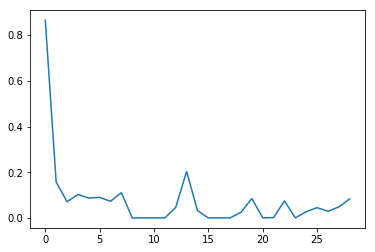

In [376]:
plt.plot(range(29),ESS[:29]/M)
plt.show()

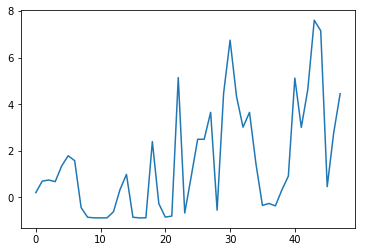

In [381]:
len_pred=49
mean_x_pred=np.zeros(len_pred-1)
for i in range(len_pred-1):
    mean_x_pred[i]=np.median(x[i,:])
plt.plot(range(len_pred-1),(mean_x_pred[:len_pred-1]-consumption_day_ahead[:len_pred-1])/consumption_day_ahead[:len_pred-1])
plt.show()

In [357]:
mean_x_pred[:29]

array([  68205.0413849 ,  152416.89238443,  184685.95287037,
        196565.26984717,  106156.54734684,  131657.55815708,
        138378.3830604 ,   40326.16941093,   23763.2612612 ,
         22187.00143301,   22709.17896239,   23400.3582001 ,
         48008.53531511,  121684.24048223,  203327.43244025,
         26164.78724997,   31087.23508839,   31269.55052663,
        330528.83374145,  221191.13890831,   32212.69262672,
         41093.70350973,  291655.68635655,   41554.97324632,
        308916.59036458,  289891.85789991,  600997.06843208,
        515403.94585402,   66774.5666293 ])

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



#### Initialization of parameters

In [431]:
u_h_current=13
sigma_current=10**3
sigma_g_current=10**3
sigma_s_current=10**3
sigma_current=10**3

In [432]:
len_filter_pmmh=30
accept_proba=0
len_iter_mha=50
accept_log_proba=np.zeros(len_filter_pmmh)
accept_rate=0
log_lh_init=np.zeros(len_filter_pmmh)

In [433]:
lh_y_prop=np.zeros([len_filter_pmmh,M])

#### Initialization of hyperparameters

In [434]:
#standard deviation of normal/trunc normal proposals on parameters
std_hyp_sigma_g,std_hyp_sigma_s,std_hyp_sigma=np.ones(3)*10**3
std_hyp_u=1

In [435]:
#joint prior density of parameters
def log_joint_prior(u_h,sigma,sigma_g,sigma_s):
    res=0
    res=(-(u_h-14)**2)/2
    res=res+(-0.01-1)*np.log(sigma**2) - (0.01/sigma**2)
    res=res+(-0.01-1)*np.log(sigma_g**2) - (0.01/sigma_g**2)
    res=res+(-0.01-1)*np.log(sigma_s**2) - (0.01/sigma_s**2)
    return res

In [436]:
#joint log prior density initialize
log_prior_init=log_joint_prior(u_h_current,sigma_current,sigma_g_current,sigma_s_current)
print(log_prior_init)
#initial parameters otbained from Gibbs. These initialized parameters will not change through iterations

-42.3609970206


#### Run initial particle filter and get the log likelihood

In [439]:
log_lh_init=particle_filter(len_init,len_filter_pmmh,s_init,g_heat_init,sigma_s_current,sigma_g_current,sigma_current,lh_y_n)

n= 1
number of negative values: 0
x_pred_mean = 9.00e+04 real consumption= 5.75e+04
x_pred min= 1.63e+02 x_pred max 6.59e+05
ESS of normalized weights= 491.576029
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.41e+05 real consumption= 6.65e+04
x_pred min= 2.95e+03 x_pred max 8.43e+05
ESS of normalized weights= 304.99629
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.15e+05 real consumption= 6.92e+04
x_pred min= 2.59e+03 x_pred max 8.26e+05
ESS of normalized weights= 203.279761
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 1.34e+05 real consumption= 6.97e+04
x_pred min= 4.53e+03 x_pred max 7.90e+05
ESS of normalized weights= 175.081152
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.39e+05 real con

In [440]:
print(log_lh_init[len_filter_pmmh-1])

-1253587344.73


#### PMMH Algorithm

In [441]:
for step in range(len_iter_mha):
    print("___________________________________________________________")
    print("Metropolis Hastings step:",step)
    #we need 6 inputs to compute the (log) acceptance probability log(r):
    #log_likelihood, joint prior density, log proposal density for both current parameters and proposed parameters
    #sample proposal for u_h, sigma, sigma_g, sigma_s
    u_h_prop=npr.normal(u_h_current,std_hyp_u,size=1)
    sigma_prop=stats.truncnorm.rvs(a=(0-sigma_current)/std_hyp_sigma,b=np.inf,scale=std_hyp_sigma,size=1)
    sigma_g_prop=stats.truncnorm.rvs(a=(0-sigma_g_current)/std_hyp_sigma_g,b=np.inf,scale=std_hyp_sigma_g,size=1)
    sigma_s_prop=stats.truncnorm.rvs(a=(0-sigma_s_current)/std_hyp_sigma_s,b=np.inf,scale=std_hyp_sigma_s,size=1)
    print("proposed parameters:","u_heat:",u_h_prop,"sigma:",sigma_prop,"sigma_g:",sigma_g_prop,"sigma_s:",sigma_s_prop)
    #1/run a particle filter with the proposed parameters to obtain a an estimation of likelihood proposed
    #  consider the likelihood of the last day of the fitering
    lh_y_prop=particle_filter(len_init,len_filter_pmmh,s_init,g_heat_init,sigma_s_prop,sigma_g_prop,sigma_prop,lh_y_n)
    print("log likelihood proposal of y:",np.sum(lh_y_prop))
    #2/generate prior proposals and compute joint log density of them
    log_prior_prop = log_joint_prior(u_h_prop,sigma_prop,sigma_g_prop,sigma_s_prop)
    print("proposed log prior:",log_prior_prop)
    #3/compute log proposal density h(current parameter|proposed parameter)
    current_log_density=np.log(stats.norm.cdf(sigma_current/std_hyp_sigma,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_s_current/std_hyp_sigma_s,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_g_current/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density initial parameters given proposed param:",current_log_density)
    #4/log likelihood from initial parameters --> already done: log_lh_init
    #5/joint prior of the initial parameters: we already have them
    #6/compute log proposal density h(proposed parameter|current parameter)
    prop_log_density=np.log(stats.norm.cdf(sigma_prop/std_hyp_sigma,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_s_prop/std_hyp_sigma_s,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_g_prop/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density proposed parameters given current param:",prop_log_density)
    #we add up these elements to construct the log acceptance probability
    #numerator
    accept_log_proba[step]=np.sum(lh_y_prop)+log_prior_prop+current_log_density
    #denominator
    accept_log_proba[step]=accept_log_proba[step]-np.sum(log_lh_init)-log_prior_init-prop_log_density
    print("acceptance log probability:",accept_log_proba[step])
    u=npr.random()
    #to get an acceptance rate > 5%, we need log_proba to be at least -3
    if(np.log(u)<min(0,accept_log_proba[step])):
        print("ACCEPT")
        accept_rate=accept_rate+1
        log_lh_init=lh_y_prop
        sigma_current=sigma_prop
        sigma_g_current=sigma_g_prop
        sigma_s_current=sigma_s_prop
        u_h_current=u_h_prop
    else:
        print("REJECT")

___________________________________________________________
Metropolis Hastings step: 0
proposed parameters: u_heat: [ 13.03616062] sigma: [ 980.127823] sigma_g: [-689.51584796] sigma_s: [-234.74766312]
n= 1
number of negative values: 0
x_pred_mean = 8.71e+04 real consumption= 5.75e+04
x_pred min= 5.29e+02 x_pred max 5.51e+05
ESS of normalized weights= 495.391753
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.52e+05 real consumption= 6.65e+04
x_pred min= 2.68e+03 x_pred max 9.12e+05
ESS of normalized weights= 256.232104
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.64e+05 real consumption= 6.92e+04
x_pred min= 1.65e+03 x_pred max 9.55e+05
ESS of normalized weights= 115.039035
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 1.97e+05 real consumption= 6.97e+04
x_pred min=

new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 3.24e+05 real consumption= 6.88e+04
x_pred min= 3.81e+03 x_pred max 1.33e+06
ESS of normalized weights= 60.384499
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negative values: 0
x_pred_mean = 2.06e+05 real consumption= 6.73e+04
x_pred min= 8.22e+03 x_pred max 1.31e+06
ESS of normalized weights= 124.048414
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 7
number of negative values: 0
x_pred_mean = 4.22e+04 real consumption= 5.90e+04
x_pred min= 7.10e+02 x_pred max 1.49e+05
ESS of normalized weights= 274.962023
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 1.08e+04 real consumption= 5.74e+04
x_pred min= 8.41e+00 x_pred max 4.77e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 9
No heating effect
numbe

new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 6.89e+04 real consumption= 7.46e+04
x_pred min= 3.35e+03 x_pred max 3.12e+05
ESS of normalized weights= 219.519364
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 8.96e+04 real consumption= 6.83e+04
x_pred min= 7.58e+02 x_pred max 3.57e+05
ESS of normalized weights= 157.011904
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 9.62e+03 real consumption= 6.50e+04
x_pred min= 9.27e+00 x_pred max 6.08e+04
ESS of normalized weights= 1.000216
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+04 real consumption= 8.17e+04
x_pred min= 6.58e+00 x_pred max 8.02e+04
ESS of normalized weights= 2.166622
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating e

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


2.84e+04 real consumption= 7.34e+04
x_pred min= 2.19e+02 x_pred max 1.40e+05
ESS of normalized weights= 31.437301
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 7.23e+04 real consumption= 7.46e+04
x_pred min= 1.34e+02 x_pred max 2.56e+05
ESS of normalized weights= 160.591077
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 1.35e+05 real consumption= 6.83e+04
x_pred min= 2.94e+03 x_pred max 3.67e+05
ESS of normalized weights= 88.818154
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 1.25e+04 real consumption= 6.50e+04
x_pred min= 7.23e-02 x_pred max 4.39e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 1.33e+04 real consumption= 8.17e+04
x_pred min= 2

new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 1.40e+05 real consumption= 7.77e+04
x_pred min= 2.43e+03 x_pred max 7.18e+05
ESS of normalized weights= 93.17701
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 1.49e+04 real consumption= 7.82e+04
x_pred min= 3.18e+01 x_pred max 5.04e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 1.55e+04 real consumption= 6.41e+04
x_pred min= 2.15e+00 x_pred max 6.47e+04
ESS of normalized weights= 2.995464
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 3.79e+05 real consumption= 5.73e+04
x_pred min= 8.85e+02 x_pred max 1.99e+06
ESS of normalized weights= 19.339027
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 23
number of negative v

number of negative values: 0
x_pred_mean = 9.77e+04 real consumption= 6.15e+04
x_pred min= 8.95e+03 x_pred max 2.08e+05
ESS of normalized weights= 187.429358
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 29
number of negative values: 0
x_pred_mean = 1.30e+06 real consumption= 5.56e+04
x_pred min= 6.75e+04 x_pred max 2.71e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
log likelihood proposal of y: -46247942409.4
proposed log prior: [-41.25164599]
proposal log density initial parameters given proposed param: -0.51826133707
proposal log density proposed parameters given current param: [-0.71324758]
acceptance log probability: -41241275950.5
REJECT
___________________________________________________________
Metropolis Hastings step: 6
proposed parameters: u_heat: [ 11.81887076] sigma: [-606.99551442] sigma_g: [ 325.35729927] sigma_s: [-421.53524651]
n= 1
number of negative values: 0
x_pred_mean = 8.87e+04 real consumpti

new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.46e+05 real consumption= 6.65e+04
x_pred min= 4.35e+03 x_pred max 8.62e+05
ESS of normalized weights= 121.046451
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.37e+05 real consumption= 6.92e+04
x_pred min= 7.48e+02 x_pred max 1.04e+06
ESS of normalized weights= 143.840869
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 2.27e+05 real consumption= 6.97e+04
x_pred min= 3.00e+03 x_pred max 1.29e+06
ESS of normalized weights= 91.305456
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.69e+05 real consumption= 6.88e+04
x_pred min= 3.04e+02 x_pred max 1.00e+06
ESS of normalized weights= 92.573942
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negative 

new ESS= 10000.0
------------------------
n= 7
number of negative values: 0
x_pred_mean = 2.55e+04 real consumption= 5.90e+04
x_pred min= 3.80e+02 x_pred max 7.94e+04
ESS of normalized weights= 40.243079
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 1.69e+04 real consumption= 5.74e+04
x_pred min= 7.19e+00 x_pred max 7.52e+04
ESS of normalized weights= 1.507415
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 9
No heating effect
number of negative values: 0
x_pred_mean = 1.77e+04 real consumption= 6.93e+04
x_pred min= 5.51e-01 x_pred max 8.22e+04
ESS of normalized weights= 2.707895
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 10
No heating effect
number of negative values: 0
x_pred_mean = 1.86e+04 real consumption= 7.06e+04
x_pred min= 1.23e+01 x_pred max 9.11e+04
ESS of normalized weights= 2.664972
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 11
No heating effec

new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 7.43e+04 real consumption= 7.46e+04
x_pred min= 4.47e+02 x_pred max 4.08e+05
ESS of normalized weights= 78.912126
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 1.03e+05 real consumption= 6.83e+04
x_pred min= 5.99e+02 x_pred max 4.53e+05
ESS of normalized weights= 87.471613
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 6.33e+03 real consumption= 6.50e+04
x_pred min= 1.84e-01 x_pred max 4.36e+04
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 7.44e+03 real consumption= 8.17e+04
x_pred min= 8.03e-01 x_pred max 4.83e+04
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 17
No heating e

new ESS= 10000.0
------------------------
n= 18
number of negative values: 0
x_pred_mean = 3.08e+05 real consumption= 7.90e+04
x_pred min= 3.02e+03 x_pred max 9.59e+05
ESS of normalized weights= 149.090631
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 1.00e+05 real consumption= 7.77e+04
x_pred min= 7.22e+02 x_pred max 6.13e+05
ESS of normalized weights= 897.527945
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 3.50e+04 real consumption= 7.82e+04
x_pred min= 8.84e-01 x_pred max 1.02e+05
ESS of normalized weights= 3.268677
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 3.54e+04 real consumption= 6.41e+04
x_pred min= 6.62e-01 x_pred max 1.15e+05
ESS of normalized weights= 13.45052
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n=

new ESS= 10000.0
------------------------
n= 25
number of negative values: 0
x_pred_mean = 5.55e+05 real consumption= 6.76e+04
x_pred min= 6.96e+03 x_pred max 2.03e+06
ESS of normalized weights= 27.867641
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 26
number of negative values: 0
x_pred_mean = 4.83e+05 real consumption= 6.68e+04
x_pred min= 8.04e+03 x_pred max 2.11e+06
ESS of normalized weights= 15.134693
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 27
number of negative values: 0
x_pred_mean = 5.01e+05 real consumption= 6.73e+04
x_pred min= 1.79e+03 x_pred max 2.10e+06
ESS of normalized weights= 16.111562
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 28
number of negative values: 0
x_pred_mean = 3.73e+04 real consumption= 6.15e+04
x_pred min= 1.95e+03 x_pred max 1.01e+05
ESS of normalized weights= 235.314683
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 29
number of negat

new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.53e+05 real consumption= 6.65e+04
x_pred min= 3.36e+02 x_pred max 1.27e+06
ESS of normalized weights= 184.452213
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 2.12e+05 real consumption= 6.92e+04
x_pred min= 1.01e+03 x_pred max 1.23e+06
ESS of normalized weights= 118.927287
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 2.45e+05 real consumption= 6.97e+04
x_pred min= 8.36e+02 x_pred max 1.28e+06
ESS of normalized weights= 68.185211
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.63e+05 real consumption= 6.88e+04
x_pred min= 1.25e+03 x_pred max 7.90e+05
ESS of normalized weights= 97.70034
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negative v

number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 6.73e+04
x_pred min= 7.11e+02 x_pred max 5.33e+05
ESS of normalized weights= 206.189193
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 7
number of negative values: 0
x_pred_mean = 1.96e+04 real consumption= 5.90e+04
x_pred min= 3.44e+02 x_pred max 9.56e+04
ESS of normalized weights= 143.29042
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 7.67e+03 real consumption= 5.74e+04
x_pred min= 1.26e+01 x_pred max 2.99e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 9
No heating effect
number of negative values: 0
x_pred_mean = 8.06e+03 real consumption= 6.93e+04
x_pred min= 1.58e+01 x_pred max 4.29e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 10
No heating effect
number of negative values: 0
x_pred_mean = 8.49e+03 real

new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 9.98e+04 real consumption= 6.83e+04
x_pred min= 1.09e+03 x_pred max 3.94e+05
ESS of normalized weights= 1135.444981
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 1.74e+04 real consumption= 6.50e+04
x_pred min= 2.78e+00 x_pred max 6.80e+04
ESS of normalized weights= 8.313293
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 1.88e+04 real consumption= 8.17e+04
x_pred min= 1.62e-01 x_pred max 9.04e+04
ESS of normalized weights= 42.678739
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 17
No heating effect
number of negative values: 0
x_pred_mean = 1.99e+04 real consumption= 8.01e+04
x_pred min= 3.09e+01 x_pred max 6.02e+04
ESS of normalized weights= 1.045527
ESS <0.001*M
new ESS= 10000.0
------------------------


new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 2.20e+05 real consumption= 7.77e+04
x_pred min= 2.32e+03 x_pred max 7.27e+05
ESS of normalized weights= 120.000599
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 3.70e+04 real consumption= 7.82e+04
x_pred min= 2.41e+01 x_pred max 1.30e+05
ESS of normalized weights= 707.615895
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 1.74e+04 real consumption= 6.41e+04
x_pred min= 5.82e+00 x_pred max 7.13e+04
ESS of normalized weights= 32.549138
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 3.73e+05 real consumption= 5.73e+04
x_pred min= 1.33e+04 x_pred max 1.22e+06
ESS of normalized weights= 12.996279
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
---------

new ESS= 10000.0
------------------------
n= 25
number of negative values: 0
x_pred_mean = 4.16e+05 real consumption= 6.76e+04
x_pred min= 3.66e+03 x_pred max 1.75e+06
ESS of normalized weights= 37.874087
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 26
number of negative values: 0
x_pred_mean = 4.57e+05 real consumption= 6.68e+04
x_pred min= 3.24e+03 x_pred max 2.20e+06
ESS of normalized weights= 57.687635
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 27
number of negative values: 0
x_pred_mean = 4.51e+05 real consumption= 6.73e+04
x_pred min= 1.05e+03 x_pred max 1.98e+06
ESS of normalized weights= 31.165279
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 28
number of negative values: 0
x_pred_mean = 4.01e+04 real consumption= 6.15e+04
x_pred min= 4.54e+02 x_pred max 1.27e+05
ESS of normalized weights= 696.750189
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 29
number of negat

new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.36e+05 real consumption= 6.65e+04
x_pred min= 2.12e+03 x_pred max 1.00e+06
ESS of normalized weights= 695.879887
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.57e+05 real consumption= 6.92e+04
x_pred min= 4.05e+03 x_pred max 1.01e+06
ESS of normalized weights= 383.643333
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 2.02e+05 real consumption= 6.97e+04
x_pred min= 7.12e+03 x_pred max 9.29e+05
ESS of normalized weights= 184.259395
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.82e+05 real consumption= 6.88e+04
x_pred min= 1.21e+03 x_pred max 6.92e+05
ESS of normalized weights= 176.828697
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negativ

number of negative values: 0
x_pred_mean = 1.20e+05 real consumption= 6.73e+04
x_pred min= 1.10e+03 x_pred max 7.11e+05
ESS of normalized weights= 260.903248
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 7
number of negative values: 0
x_pred_mean = 2.54e+04 real consumption= 5.90e+04
x_pred min= 1.28e+02 x_pred max 1.34e+05
ESS of normalized weights= 324.98469
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 5.85e+03 real consumption= 5.74e+04
x_pred min= 6.12e-01 x_pred max 4.42e+04
ESS of normalized weights= 1.289928
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 9
No heating effect
number of negative values: 0
x_pred_mean = 6.76e+03 real consumption= 6.93e+04
x_pred min= 2.57e+00 x_pred max 5.78e+04
ESS of normalized weights= 1.000017
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 10
No heating effect
number of negative values: 0
x_pred_mean = 7.7

x_pred_mean = 1.12e+04 real consumption= 7.21e+04
x_pred min= 4.97e-01 x_pred max 7.33e+04
ESS of normalized weights= 2.35963
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 12
number of negative values: 0
x_pred_mean = 4.08e+04 real consumption= 7.34e+04
x_pred min= 1.15e+03 x_pred max 1.78e+05
ESS of normalized weights= 512.565276
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 1.10e+05 real consumption= 7.46e+04
x_pred min= 2.50e+03 x_pred max 3.85e+05
ESS of normalized weights= 691.938316
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 1.60e+05 real consumption= 6.83e+04
x_pred min= 8.63e+02 x_pred max 6.70e+05
ESS of normalized weights= 601.965888
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 1.93e+04 real consumption= 6.50e+04
x_pred min=

number of negative values: 0
x_pred_mean = 2.96e+05 real consumption= 7.90e+04
x_pred min= 2.10e+03 x_pred max 1.53e+06
ESS of normalized weights= 133.919421
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 1.43e+05 real consumption= 7.77e+04
x_pred min= 1.36e+03 x_pred max 4.53e+05
ESS of normalized weights= 279.025497
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 1.12e+04 real consumption= 7.82e+04
x_pred min= 3.07e-01 x_pred max 4.83e+04
ESS of normalized weights= 1.006997
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 1.27e+04 real consumption= 6.41e+04
x_pred min= 1.44e+00 x_pred max 6.62e+04
ESS of normalized weights= 9.03296
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 3.18e+05 real cons

new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 4.44e+05 real consumption= 5.73e+04
x_pred min= 3.24e+03 x_pred max 1.58e+06
ESS of normalized weights= 59.197206
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 23
number of negative values: 0
x_pred_mean = 3.59e+04 real consumption= 6.58e+04
x_pred min= 3.61e+02 x_pred max 1.07e+05
ESS of normalized weights= 66.734796
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 24
number of negative values: 0
x_pred_mean = 8.44e+05 real consumption= 6.64e+04
x_pred min= 2.29e+03 x_pred max 2.50e+06
ESS of normalized weights= 45.897472
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 25
number of negative values: 0
x_pred_mean = 1.26e+06 real consumption= 6.76e+04
x_pred min= 5.09e+03 x_pred max 3.56e+06
ESS of normalized weights= 30.808047
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 26
number of negati

new ESS= 10000.0
------------------------
n= 26
number of negative values: 0
x_pred_mean = 6.88e+05 real consumption= 6.68e+04
x_pred min= 1.14e+04 x_pred max 2.26e+06
ESS of normalized weights= 15.329851
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 27
number of negative values: 0
x_pred_mean = 6.19e+05 real consumption= 6.73e+04
x_pred min= 4.09e+03 x_pred max 1.57e+06
ESS of normalized weights= 8.524174
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 28
number of negative values: 0
x_pred_mean = 4.66e+04 real consumption= 6.15e+04
x_pred min= 1.08e+03 x_pred max 1.37e+05
ESS of normalized weights= 1272.986726
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 29
number of negative values: 0
x_pred_mean = 5.20e+05 real consumption= 5.56e+04
x_pred min= 7.38e+03 x_pred max 1.14e+06
ESS of normalized weights= 18.949688
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
log likelihood proposal of y: -273816

new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.86e+05 real consumption= 6.65e+04
x_pred min= 2.00e+03 x_pred max 1.39e+06
ESS of normalized weights= 402.595392
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.71e+05 real consumption= 6.92e+04
x_pred min= 2.15e+02 x_pred max 1.01e+06
ESS of normalized weights= 402.727679
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 2.08e+05 real consumption= 6.97e+04
x_pred min= 1.41e+03 x_pred max 1.04e+06
ESS of normalized weights= 255.303039
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.81e+05 real consumption= 6.88e+04
x_pred min= 9.92e+02 x_pred max 1.13e+06
ESS of normalized weights= 383.250303
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negativ

number of negative values: 0
x_pred_mean = 2.59e+04 real consumption= 5.90e+04
x_pred min= 1.37e+02 x_pred max 9.69e+04
ESS of normalized weights= 243.162977
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 1.35e+04 real consumption= 5.74e+04
x_pred min= 6.93e+00 x_pred max 4.78e+04
ESS of normalized weights= 1.089657
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 9
No heating effect
number of negative values: 0
x_pred_mean = 1.43e+04 real consumption= 6.93e+04
x_pred min= 2.64e+00 x_pred max 5.95e+04
ESS of normalized weights= 1.001593
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 10
No heating effect
number of negative values: 0
x_pred_mean = 1.51e+04 real consumption= 7.06e+04
x_pred min= 4.65e+00 x_pred max 8.14e+04
ESS of normalized weights= 2.382651
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 11
No heating effect
number of negative values: 0
x_pred_mean = 1

new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 7.93e+04 real consumption= 6.83e+04
x_pred min= 1.27e+03 x_pred max 2.54e+05
ESS of normalized weights= 889.420721
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 8.42e+03 real consumption= 6.50e+04
x_pred min= 3.19e+00 x_pred max 5.14e+04
ESS of normalized weights= 1.000291
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 9.01e+03 real consumption= 8.17e+04
x_pred min= 1.21e-02 x_pred max 6.30e+04
ESS of normalized weights= 1.407797
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating effect
number of negative values: 0
x_pred_mean = 9.62e+03 real consumption= 8.01e+04
x_pred min= 1.54e+00 x_pred max 6.53e+04
ESS of normalized weights= 1.119144
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 18
number of ne

number of negative values: 0
x_pred_mean = 1.28e+05 real consumption= 7.90e+04
x_pred min= 2.75e+02 x_pred max 5.82e+05
ESS of normalized weights= 339.161191
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 7.26e+04 real consumption= 7.77e+04
x_pred min= 4.83e+02 x_pred max 2.29e+05
ESS of normalized weights= 809.300702
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 3.14e+04 real consumption= 7.82e+04
x_pred min= 1.05e+01 x_pred max 9.38e+04
ESS of normalized weights= 622.326251
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 2.85e+04 real consumption= 6.41e+04
x_pred min= 1.76e+00 x_pred max 9.40e+04
ESS of normalized weights= 753.428071
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 22
number of negative value

new ESS= 10000.0
------------------------
n= 24
number of negative values: 0
x_pred_mean = 4.60e+05 real consumption= 6.64e+04
x_pred min= 1.07e+04 x_pred max 1.82e+06
ESS of normalized weights= 68.645399
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 25
number of negative values: 0
x_pred_mean = 4.87e+05 real consumption= 6.76e+04
x_pred min= 6.56e+03 x_pred max 2.01e+06
ESS of normalized weights= 126.48186
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 26
number of negative values: 0
x_pred_mean = 7.03e+05 real consumption= 6.68e+04
x_pred min= 1.12e+04 x_pred max 3.10e+06
ESS of normalized weights= 68.866111
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 27
number of negative values: 0
x_pred_mean = 4.08e+05 real consumption= 6.73e+04
x_pred min= 1.15e+04 x_pred max 2.07e+06
ESS of normalized weights= 106.283034
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 28
number of negat

IndexError: index 30 is out of bounds for axis 0 with size 30

In [442]:
print(accept_rate/len_iter_mha)

0.04


In [333]:
sigma_prop

array([ 210.87315274])

In [706]:
np.exp(-3)

0.049787068367863944

In [541]:
log_lh_init

-799691.61253114953